In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import mean_squared_error

from scipy.stats import median_abs_deviation

import warnings
warnings.filterwarnings('ignore')

from user_defined_funcs import *

In [2]:
raw_df = load_data()

In [3]:
raw_df.head()

,Datetime,Power_MWH
0,2010-01-01 00:00:00,31647.0
1,2010-12-31 01:00:00,29634.0
2,2010-12-31 02:00:00,28614.0
3,2010-12-31 03:00:00,28146.0
4,2010-12-31 04:00:00,28051.0


<Axes: ylabel='Frequency'>

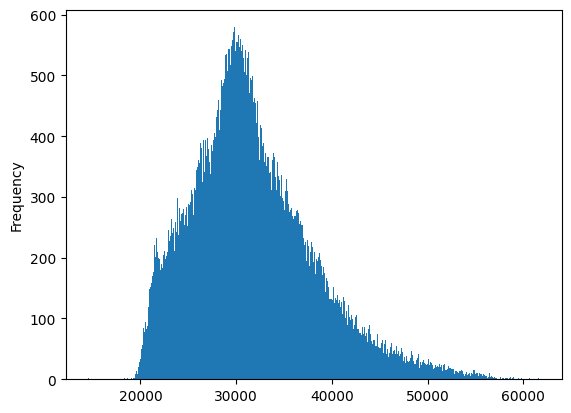

In [4]:
raw_df['Power_MWH'].plot(kind='hist', bins=500)

<Axes: >

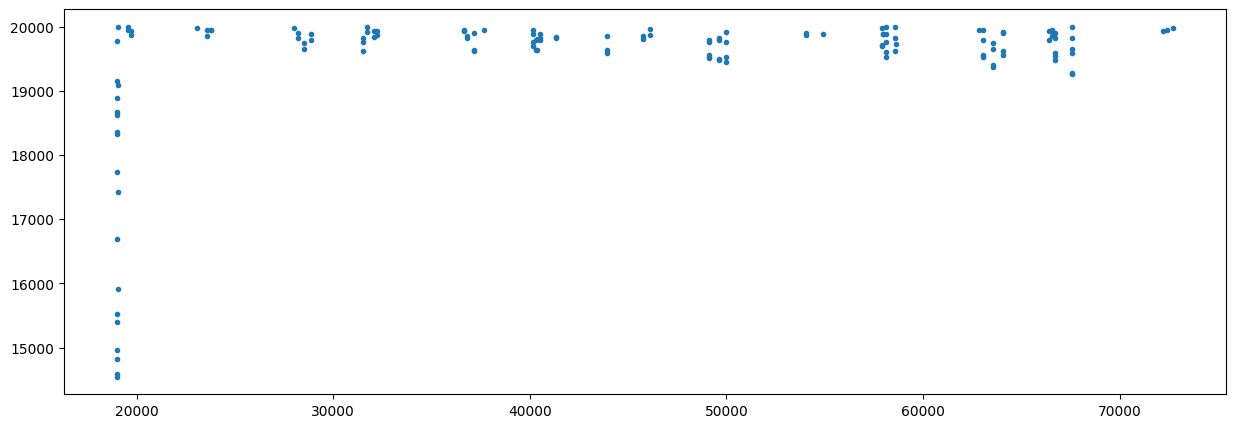

In [5]:
raw_df.query('Power_MWH < 20_000')['Power_MWH'].plot(style='.', figsize=(15, 5))

<Axes: title={'center': 'Outliers'}>

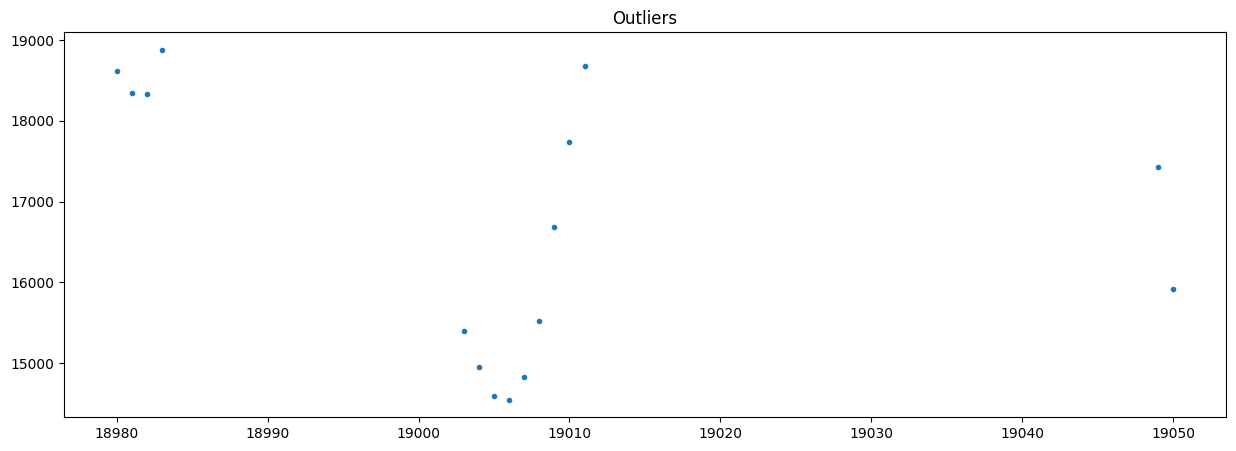

In [6]:
# Remove Power values less than 19k

raw_df.query('Power_MWH < 19_000')['Power_MWH'].plot(style='.', figsize=(15, 5), title='Outliers')

In [7]:
df_gt_19k = raw_df.query('Power_MWH > 19_000')

In [8]:
df_gt_19k.sort_values('Power_MWH').head()

,Datetime,Power_MWH
19048,2012-10-29 22:00:00,19085.0
18979,2012-10-31 01:00:00,19155.0
67581,2017-04-16 05:00:00,19255.0
67580,2017-04-16 04:00:00,19278.0
63549,2017-10-01 05:00:00,19367.0


<Axes: title={'center': 'Power Consumption'}, xlabel='Datetime'>

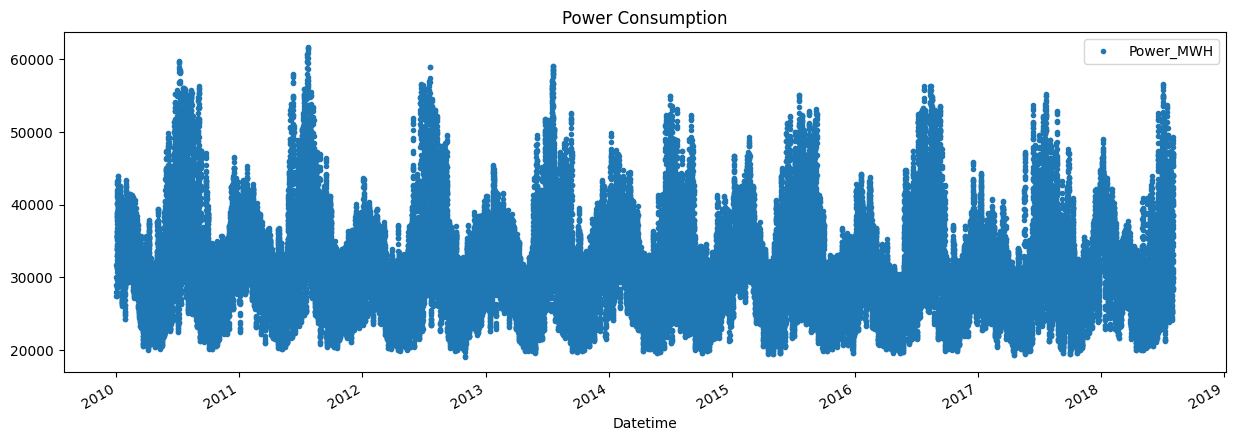

In [9]:
df_gt_19k_indexed = set_index(df_gt_19k)
df_gt_19k_indexed.plot(style='.', figsize=(15, 5), title='Power Consumption')

# Anamoly Detection using Median Absolute Deviation(MAD)
* Possible because data is close to normal distribution

In [10]:
df_gt_19k['Power_MWH'].median()

np.float64(30839.0)

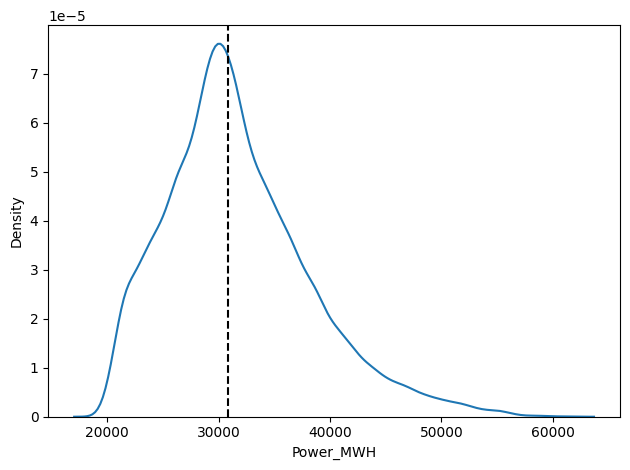

In [11]:
sns.kdeplot(df_gt_19k['Power_MWH'])
plt.grid(False)
plt.axvline(df_gt_19k['Power_MWH'].median(), c='black', ls='--')
plt.tight_layout()

In [12]:
mad = median_abs_deviation(df_gt_19k['Power_MWH'])
median = np.median(df_gt_19k['Power_MWH'])

print(mad, median)

def compute_robust_z_score(x):
    return 0.6745 * (x-median) / mad

4009.0 30839.0


In [13]:
# Compute the robust Z-score for each sample

df_gt_19k['z-score'] = df_gt_19k['Power_MWH'].apply(compute_robust_z_score)
df_gt_19k.head()

,Datetime,Power_MWH,z-score
0,2010-01-01 00:00:00,31647.0,0.135943
1,2010-12-31 01:00:00,29634.0,-0.202737
2,2010-12-31 02:00:00,28614.0,-0.374348
3,2010-12-31 03:00:00,28146.0,-0.453088
4,2010-12-31 04:00:00,28051.0,-0.469071


In [14]:
# Determine if it is an anamoly (use a threshold of 3.5)
# -1 is anamoly, 1 is normal

df_gt_19k['anamoly'] = 1

df_gt_19k.loc[df_gt_19k['z-score'] >= 3.5, 'anamoly'] = -1
df_gt_19k.loc[df_gt_19k['z-score'] <= -3.5, 'anamoly'] = -1

In [15]:
df_gt_19k.head()

,Datetime,Power_MWH,z-score,anamoly
0,2010-01-01 00:00:00,31647.0,0.135943,1
1,2010-12-31 01:00:00,29634.0,-0.202737,1
2,2010-12-31 02:00:00,28614.0,-0.374348,1
3,2010-12-31 03:00:00,28146.0,-0.453088,1
4,2010-12-31 04:00:00,28051.0,-0.469071,1


In [16]:
df_gt_19k.groupby('anamoly')['Power_MWH'].count()

anamoly
-1      636
 1    74604
Name: Power_MWH, dtype: int64

In [17]:
df_without_anamoly = df_gt_19k[df_gt_19k['anamoly'] == 1]
df_without_anamoly = df_without_anamoly[['Datetime', 'Power_MWH']]

<Axes: title={'center': 'Power Consumption'}, xlabel='Datetime'>

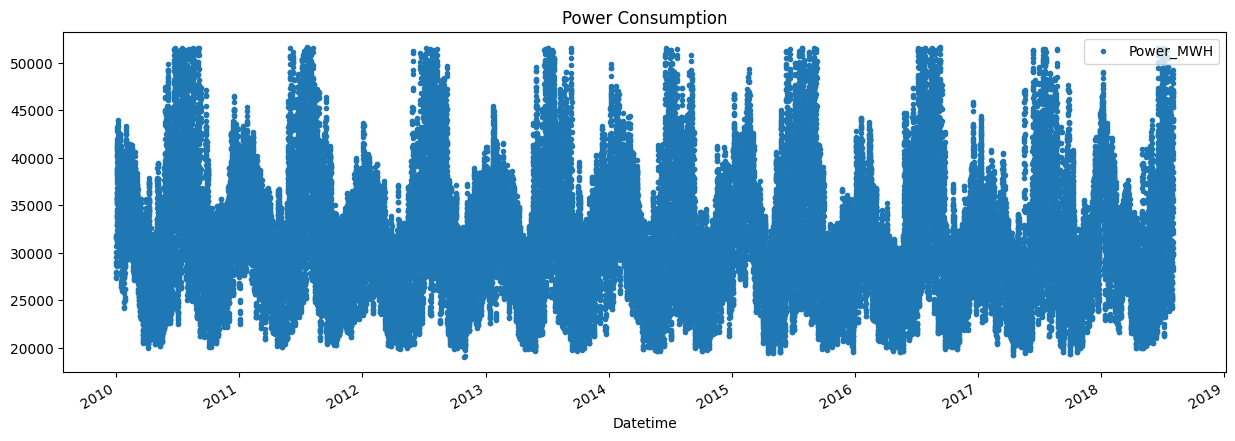

In [18]:
df_without_anamoly_indexed = set_index(df_without_anamoly)
df_without_anamoly_indexed.plot(style='.', figsize=(15, 5), title='Power Consumption')

In [19]:
train = df_without_anamoly_indexed.loc[df_without_anamoly_indexed.index < '01-01-2017']
test = df_without_anamoly_indexed.loc[df_without_anamoly_indexed.index >= '01-01-2017']

df = create_features(df_without_anamoly_indexed)

train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'Power_MWH'


X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Create our model

In [20]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:4979.91063	validation_1-rmse:4944.96245
[99]	validation_0-rmse:1438.93479	validation_1-rmse:4675.59445


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Changing Hyper-Parameter

In [21]:
reg_hyper = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds= 10, learning_rate = 0.008)
reg_hyper.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)

[0]	validation_0-rmse:6193.74636	validation_1-rmse:5977.03905
[50]	validation_0-rmse:4824.66273	validation_1-rmse:4834.12681
[100]	validation_0-rmse:4023.81619	validation_1-rmse:4283.73471
[150]	validation_0-rmse:3549.47520	validation_1-rmse:4024.24715
[200]	validation_0-rmse:3265.53510	validation_1-rmse:3902.67394
[250]	validation_0-rmse:3075.38311	validation_1-rmse:3843.94999
[300]	validation_0-rmse:2943.16023	validation_1-rmse:3808.78853
[350]	validation_0-rmse:2850.57687	validation_1-rmse:3801.58860
[361]	validation_0-rmse:2834.21936	validation_1-rmse:3802.62738


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.008, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
test['prediction'] = reg_hyper.predict(X_test)

score = np.sqrt(mean_squared_error(test['Power_MWH'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3801.24


CREDITS: 
* https://github.com/marcopeix/youtube_tutorials/blob/main/YT_02_anomaly_detection_time_series.ipynb
* https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook
